<a href="https://colab.research.google.com/github/mhdykz/colorQuantization/blob/ipynbFiles/task3-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math

In [22]:
image_path = 'peppers.tif'
image = Image.open(image_path)
image_array = np.array(image)

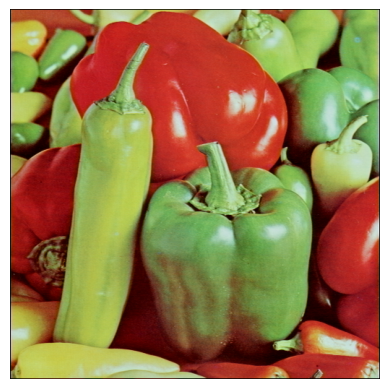

type of array <class 'numpy.ndarray'>
size of array: (262144, 3)
how many D? 2 D


In [23]:
plt.imshow(image_array)
plt.axis('off')
plt.show()

reshaped_image = image_array.reshape(-1, 3)

print("type of array", type(reshaped_image))
print("size of array:", reshaped_image.shape)
print("how many D?", reshaped_image.ndim, "D")

Chosing Random k-point

C:\Users\Arash\AppData\Local\Temp\ipykernel_14324\3002120107.py:3: RuntimeWarning: overflow encountered in scalar add
  return (point1[0] - point2[0])**2 + (point1[1] - point2[1])**2 + (point1[2] - point2[2])**2
C:\Users\Arash\AppData\Local\Temp\ipykernel_14324\3002120107.py:3: RuntimeWarning: overflow encountered in scalar subtract
  return (point1[0] - point2[0])**2 + (point1[1] - point2[1])**2 + (point1[2] - point2[2])**2
C:\Users\Arash\AppData\Local\Temp\ipykernel_14324\3002120107.py:28: RuntimeWarning: overflow encountered in scalar add
  sumDis = sum(weight_distance)


Clusters with RGB and X, Y coordinates:
[[199.  44.  40.  73. 211.]
 [194. 200.  81.  34.  12.]
 [124.  67.  29.  14. 459.]
 [132.  15.  18. 201.  62.]
 [103. 114.  61.  55. 439.]
 [139.  16.  28. 397. 499.]
 [126.  97.  52. 365. 229.]
 [181. 203.  82. 174. 182.]
 [159. 181.  80. 252. 129.]
 [210.  56.  38. 136. 358.]
 [  0.   0.   0.   0.   0.]
 [172. 167.  71. 215. 423.]
 [212. 111.  88. 169. 224.]
 [196.  49.  39.  21. 217.]
 [116. 172.  81.  69. 483.]
 [185. 183.  62. 420.  10.]]


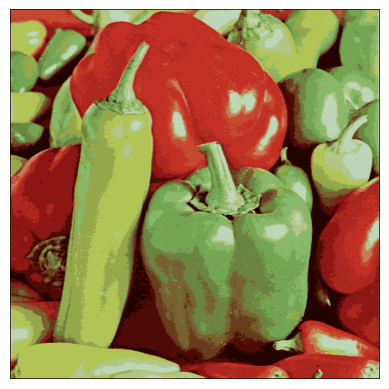

In [24]:
from sklearn.metrics import pairwise_distances_argmin 
def distancePow2(point1, point2):
    return (point1[0] - point2[0])**2 + (point1[1] - point2[1])**2 + (point1[2] - point2[2])**2
def findNearestPointDistance(k_points, point):
    min_dis = float('inf')
    for k in k_points:
        thisDistance = distancePow2(k, point)
        if thisDistance < min_dis:
            min_dis = thisDistance
    return min_dis        
def makeKRandomPoints(k, array):
    random_index = np.random.randint(array.shape[0])
    first_point = array[random_index]
    k_points = [first_point]

    for i in range(1, k): 
        weight_distance = []
        for point in reshaped_image:
            weight_distance.append(findNearestPointDistance(k_points, point))
        sumDis = sum(weight_distance)
        weight_distance = [d / sumDis for d in weight_distance]
        weight_distance = np.clip(weight_distance, 0, 1)
        weight_distance /= np.sum(weight_distance)
        random_pixel_index = np.random.choice(array.shape[0], p=weight_distance)
        k_points.append(array[random_pixel_index])
        
    return k_points
centroids = makeKRandomPoints(16, reshaped_image)

clusters = np.zeros((16, 5))
for idx, centroid in enumerate(centroids):
    clusters[idx, :3] = centroid
    coords = np.argwhere(np.all(image_array == centroid, axis=-1))
    if len(coords) > 0:
        clusters[idx, 3:] = coords[0]  
    else:
        clusters[idx, 3:] = [0, 0]  

print("Clusters with RGB and X, Y coordinates:")
print(clusters)
######################################################
######################################################
def assignPixelsToCentroids(centroids_rgb, pixels):
    labels = pairwise_distances_argmin(pixels, centroids_rgb)
    return labels

def updateCentroidsWithCoords(pixels, labels, k, image_array):
    new_centroids = np.zeros((k, 5))
    height, width, _ = image_array.shape
    for i in range(k):
        assigned_pixels = pixels[labels == i]
        
        if len(assigned_pixels) > 0:
            new_centroids[i, :3] = np.mean(assigned_pixels, axis=0)
            assigned_indices = np.argwhere(labels == i)
            assigned_coords = np.array([[idx // width, idx % width] for idx in assigned_indices.flatten()])
            if len(assigned_coords) > 0:
                new_centroids[i, 3:] = np.mean(assigned_coords, axis=0)
            else:
                new_centroids[i, 3:] = clusters[i, 3:]  
        else:
            new_centroids[i, :3] = clusters[i, :3]
            new_centroids[i, 3:] = clusters[i, 3:]

    return new_centroids

def kMeansClustering(pixels, k, centroids):
    max_iterations = 10  
    centroids_rgb = centroids[:, :3]  
    for _ in range(max_iterations):
        labels = assignPixelsToCentroids(centroids_rgb, pixels)
        centroids = updateCentroidsWithCoords(pixels, labels, k, image_array)
        centroids_rgb = centroids[:, :3] 
    return centroids, labels

final_clusters, final_labels = kMeansClustering(reshaped_image, 16, clusters)

clusters[:, :3] = final_clusters[:, :3]
clusters[:, 3:] = final_clusters[:, 3:]

optimized_image_array = np.array([clusters[label, :3] for label in final_labels])

optimized_image = optimized_image_array.reshape(image_array.shape)

plt.imshow(np.uint8(optimized_image))
plt.axis('off')
plt.show()

